Reference:
1. https://github.com/LydiaXiaohongLi/GaussianMixture (code from)
2. https://www.youtube.com/watch?v=qMTuMa86NzU        (explanation 1)
3. https://www.youtube.com/watch?v=xy96ArOpntA        (explanation 2 - i havn't watched it; but seems pretty good)


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [60]:
class GaussianMixture:
    def __init__(self, k, max_iter=10):
        self.k = k
        self.max_iter = max_iter

    def fit(self, X):
        n_samples = X.shape[0]
        feature_dim = X.shape[1]

        # Random initialization
        self.centers = np.random.random([self.k, feature_dim]) * np.max(X, axis=0)
        self.covs = np.random.random([self.k, feature_dim]) * np.square(np.std(X, axis=0))

        self.scale = np.random.rand(self.k)
        self.scale /= np.sum(self.scale)

        # Place holder for data_probs
        data_probs = np.zeros((n_samples, self.k))

        # estimate clusters using Expectation Maximisation (EM)
        for _ in range(self.max_iter):
            # E-Step
            for i in range(self.k):
                data_probs[:, i] = (multivariate_normal(self.centers[i], np.diag(self.covs[i])).pdf(X) * self.scale[i])
            data_probs /= np.sum(data_probs, axis=1).reshape(n_samples, 1)

            # M-Step
            self.centers = data_probs.T @ X / np.sum(data_probs, axis=0).reshape(self.k, 1)
            self.covs = np.sum(np.repeat(data_probs[:, :, np.newaxis], feature_dim, axis=2) * np.square(np.repeat(X[:, np.newaxis, :], self.k, axis=1) - self.centers), axis=0) / np.sum(data_probs, axis=0).reshape(self.k, 1)
            self.scale = np.sum(data_probs, axis=0) / np.sum(data_probs)

    def predict(self, test):
        data_probs = np.zeros((test.shape[0], self.k))

        for i in range(self.k):
            data_probs[:, i] = (multivariate_normal(self.centers[i], np.diag(self.covs[i])).pdf(test) * self.scale[i])

        return np.argmax(data_probs, axis=1)

    def sample(self, num_samples=1):
        if self.centers is None or self.covs is None:
            raise ValueError("The model has not been trained. Fit the model before sampling.")

        num_features = self.centers.shape[1]
        samples = np.zeros((num_samples, num_features))

        for i in range(num_samples):
            cluster_idx = np.random.choice(self.k, p=self.scale)
            sample = np.random.multivariate_normal(self.centers[cluster_idx], np.diag(self.covs[cluster_idx]))
            samples[i] = sample

        return samples

In [77]:
def scale(x, max_val=255):
    return ((max_val * (x - x.min()) / (x.max() - x.min())).astype('uint8'))


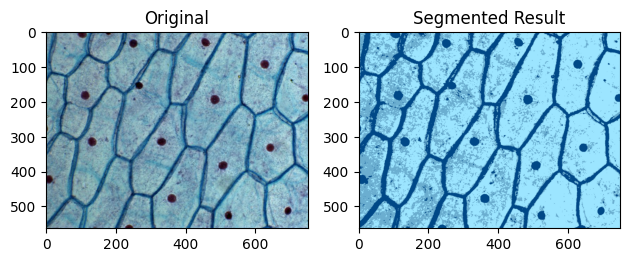

In [78]:
image = cv2.imread("./plant_cell_microscopy_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

X = image.reshape(-1,3)

gmm = GaussianMixture(k=3)
gmm.fit(X)

cluster_indexes = gmm.predict(X)
mask_img = scale(np.array([gmm.centers[i] for i in cluster_indexes]).reshape(image.shape))

plt.subplot(121)
plt.title('Original')
plt.imshow(image)

plt.subplot(122)
plt.title('Segmented Result')
plt.imshow(mask_img)

plt.tight_layout()
plt.show()


Generated Samples:
[[132.50333249 186.46817043 202.7689959 ]
 [142.01633735 171.44954889 196.05376086]
 [118.04355349 173.40039264 193.21473638]
 [129.10463938 163.24778851 203.25694605]
 [130.67019026 174.02639734 184.77919934]
 [133.14246307 194.11617777 188.25012547]
 [106.53027211 155.16384041 178.05643691]
 [116.10496689 186.93878872 178.09567139]
 [155.85389193 192.92997336 171.30414197]
 [167.01158087 172.3242768  183.36846924]]


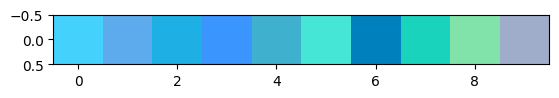

In [80]:
# Generate 10 synthetic data points
synthetic_samples = gmm.sample(num_samples=10)

# Display the generated samples
print("Generated Samples:")
print(synthetic_samples)

# scale the synthetic sample

plt.imshow(scale(synthetic_samples).reshape(1, 10, 3))
plt.show()


In [86]:
# np.diagonal(gmm.covs[0])
gmm.covs[0]

array([ 609.59686289,  844.14866533, 1017.83075065])